In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# Precinct Shapefile
---

## VEST's Documentation File

Election results from Wyoming Secretary of State (https://soswy.state.wy.us/Elections/ElectionResults.aspx)
Precinct shapefile primarily from the U.S. Census Bureau's 2020 Redistricting Data Program final release. The Fremont County shapefile was provided by the Fremont County Assessor.
 
The following modifications were made to recreate the 2018 precinct boundaries.

Albany: Consolidate 8 county VTDs into 5 precincts, 18 city VTDs into 8 precincts \ 
Campbell: Align 1-27/24-1 with Gillette municipal boundary \
Carbon: Remove district splits for 1-2, 5-1, 6-1, 7-1, 11-2, 12-1, 13-1 \
Goshen: Align VTDs with legislative districts and 2012 redistricting map \
Laramie: Adjust 03-06, 03-07 to reverse Cheyenne annexations \
Platte: Merge Y-O Ranch into Wheatland Rural \
Sheridan: Remove district splits for 01-01, 02-01, 02-03, 03-03, 11-03 \
Sweetwater: Align wards and precincts countywide with 2012 legislative redistricting \
Uinta: Remove 02-01 district split; Split 01-03/01-04; Merge 04-01/04-03 \
Weston: Adjust 5-2/5-3 boundary to match 2012 realignment

G18USSRBAR - John Barrasso (Republican Party) \
G18USSDTRA - Gary Trauner (Democratic Party) \
G18USSLPOR - Joseph Porambo (Libertarian Party) \
G18USSOWRI - Write-in Votes

G18HALRCHE - Liz Cheney (Republican Party) \
G18HALDHUN - Greg Hunter (Democratic Party) \
G18HALLBRU - Richard Brubaker (Libertarian Party) \
G18HALCCUM - Daniel Clyde Cummings (Constitution Party) \
G18HALOWRI - Write-in Votes

G18GOVRGOR - Mark Gordon (Republican Party) \
G18GOVDTHR - Mary A. Throne (Democratic Party) \
G18GOVLSTR - Lawrence Gerard Struempf (Libertarian Party) \
G18GOVCRAM - Rex "T-Rex" Rammell (Constitution Party) \
G18GOVOWRI - Write-in Votes

G18SOSRBUC - Edward Buchanan (Republican Party) \
G18SOSDBYR - James W. Byrd (Democratic Party) \
G18SOSLCAR - Kit Carson III (Libertarian Party) \
G18SOSOWRI - Write-in Votes

G18AUDRRAC - Kristi Racines (Republican Party) \
G18AUDDDOC - Jeff Dockter (Democratic Party) \
G18AUDOWRI - Write-in Votes

G18TRERMEI - Curt Meier (Republican Party) \
G18TREDLOW - Chris Lowry (Democratic Party) \
G18TREOWRI - Write-in Votes

G18SPIRBAL - Jillian Balow (Republican Party) \
G18SPIOWRI - Write-in Votes

### Load VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw_from_source/VEST/wy_2018/wy_2018.shp")

In [3]:
vest_shp.shape

(483, 31)

In [4]:
vest_shp.head()

,STATEFP20,COUNTYFP20,VTDST20,NAME20,G18USSRBAR,G18USSDTRA,G18USSLPOR,G18USSOWRI,G18HALRCHE,G18HALDHUN,...,G18SOSOWRI,G18AUDRRAC,G18AUDDDOC,G18AUDOWRI,G18TRERMEI,G18TREDLOW,G18TREOWRI,G18SPIRBAL,G18SPIOWRI,geometry
0,56,045,000101,NEWCASTLE RURAL OUTSIDE,428,64,15,2,398,73,...,0,439,63,0,447,60,0,462,4,"MULTIPOLYGON (((-104.22316 43.85669, -104.2231..."
1,56,045,000102,Northwest,327,48,13,0,311,51,...,0,332,44,0,323,54,0,335,6,"POLYGON ((-104.55704 43.85906, -104.55691 43.8..."
2,56,045,000301,UPTON OUTSIDE,201,13,5,0,195,13,...,0,197,13,0,194,17,0,194,1,"POLYGON ((-105.08141 43.82696, -105.08139 43.8..."
3,56,045,000201,OSAGE,118,10,9,0,108,8,...,0,119,13,0,119,14,0,121,2,"POLYGON ((-104.59766 43.85787, -104.59762 43.8..."
4,56,045,000501,NEWCASTLE EAST,292,51,15,1,259,68,...,0,304,45,0,295,51,0,310,4,"POLYGON ((-104.20615 43.85409, -104.20606 43.8..."


<AxesSubplot:>

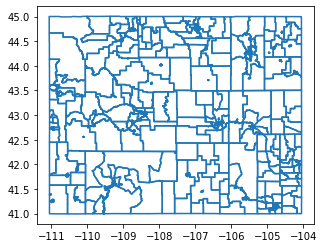

In [5]:
vest_shp.boundary.plot()

In [6]:
vest_shp.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'NAME20', 'G18USSRBAR',
       'G18USSDTRA', 'G18USSLPOR', 'G18USSOWRI', 'G18HALRCHE', 'G18HALDHUN',
       'G18HALLBRU', 'G18HALCCUM', 'G18HALOWRI', 'G18GOVRGOR', 'G18GOVDTHR',
       'G18GOVLSTR', 'G18GOVCRAM', 'G18GOVOWRI', 'G18SOSRBUC', 'G18SOSDBYR',
       'G18SOSLCAR', 'G18SOSOWRI', 'G18AUDRRAC', 'G18AUDDDOC', 'G18AUDOWRI',
       'G18TRERMEI', 'G18TREDLOW', 'G18TREOWRI', 'G18SPIRBAL', 'G18SPIOWRI',
       'geometry'],
      dtype='object')

# Election Results

## Load Files

The SOS directed to this link for election results for the 2018 general: https://soswy.state.wy.us/Elections/ElectionResults.aspx


In [7]:
#Grab the folder 
loaded_counties = os.listdir("./raw_from_source/VEST/2018_WY_Election_Results/")

#Create a list to add the county data too
li = []
#Iterate over all the counties
for file in loaded_counties:
    #Just work on the county file
    if "County_General_PbP" in file: 
        #Create the file path
        file_string = "./raw_from_source/VEST/2018_WY_Election_Results/" + file
        #Import the file
        df = pd.read_excel(file_string, 'Sheet1', index_col = [0], header = [0,1]) 
        #Filter down columns (first level of multi-index)
        df = df[['United States Senator','United States Representative','Governor','Secretary of State','State Auditor','State Treasurer','Superintendent of Public Instruction']]
        #Rename the columns to deal with the multi-index
        df.columns=['_'.join(col) if type(col) is tuple else col for col in df.columns.values]
        #Filter down columns
        df = df[['United States Senator_John\nBarrasso (R)',
       'United States Senator_Gary\nTrauner (D)',
       'United States Senator_Joseph\nPorambo (L)',
       'United States Senator_Write-Ins', 
       'United States Representative_Liz\nCheney (R)',
       'United States Representative_Greg\nHunter (D)',
       'United States Representative_Richard\nBrubaker (L)',
       'United States Representative_Daniel Clyde\nCummings (C) ',
       'United States Representative_Write-Ins',
       'Governor_Mark\nGordon (R)',
       'Governor_Mary A.\nThrone (D)',
       'Governor_Lawrence Gerard\nStruempf (L)',
       'Governor_Rex "T-Rex"\nRammell (C)', 'Governor_Write-Ins',
       'Secretary of State_Edward\nBuchanan (R)',
       'Secretary of State_James W.\nByrd (D)',
       'Secretary of State_Kit\nCarson III (L)',
       'Secretary of State_Write-Ins', 'State Auditor_Kristi\nRacines (R)',
       'State Auditor_Jeff\nDockter (D)', 'State Auditor_Write-Ins',
       'State Treasurer_Curt\nMeier (R)', 'State Treasurer_Chris\nLowry (D)',
       'State Treasurer_Write-Ins',
       'Superintendent of Public Instruction_Jillian\nBalow (R)',
       'Superintendent of Public Instruction_Write-Ins']]
        #Add the county
        df["County"] = file[5:len(file)-24]
        #Add the data to the list
        li.append(df)
        print("Working on "+ file)
#Create the final dataframe
final_results = pd.concat(li)

Working on 2018_Albany_County_General_PbP.xlsx
Working on 2018_Big_Horn_County_General_PbP.xlsx
Working on 2018_Campbell_County_General_PbP.xlsx
Working on 2018_Carbon_County_General_PbP.xlsx
Working on 2018_Converse_County_General_PbP.xlsx
Working on 2018_Crook_County_General_PbP.xlsx
Working on 2018_Fremont_County_General_PbP.xlsx
Working on 2018_Goshen_County_General_PbP.xlsx
Working on 2018_Hot_Springs_County_General_PbP.xlsx
Working on 2018_Johnson_County_General_PbP.xlsx
Working on 2018_Laramie_County_General_PbP.xlsx
Working on 2018_Lincoln_County_General_PbP.xlsx
Working on 2018_Natrona_County_General_PbP.xlsx
Working on 2018_Niobrara_County_General_PbP.xlsx
Working on 2018_Park_County_General_PbP.xlsx
Working on 2018_Platte_County_General_PbP.xlsx
Working on 2018_Sheridan_County_General_PbP.xlsx
Working on 2018_Sublette_County_General_PbP.xlsx
Working on 2018_Sweetwater_County_General_PbP.xlsx
Working on 2018_Teton_County_General_PbP.xlsx
Working on 2018_Uinta_County_General_P

### Clean Up the Election Results

In [8]:
#Deal with the index
final_results.reset_index(drop=False,inplace=True)

#Rename the columns to match VEST
final_results.columns = ["Precinct",'G18USSRBAR','G18USSDTRA','G18USSLPOR','G18USSOWRI',
       'G18HALRCHE', 'G18HALDHUN', 'G18HALLBRU', 'G18HALCCUM', 'G18HALOWRI',
       'G18GOVRGOR', 'G18GOVDTHR', 'G18GOVLSTR', 'G18GOVCRAM', 'G18GOVOWRI',
       'G18SOSRBUC','G18SOSDBYR','G18SOSLCAR','G18SOSOWRI','G18AUDRRAC','G18AUDDDOC','G18AUDOWRI',
       'G18TRERMEI','G18TREDLOW','G18TREOWRI','G18SPIRBAL','G18SPIOWRI','County']

#Remove the rows with Total votes
final_results = final_results[final_results["Precinct"]!="Total"]

#Fill n/a values with 0
final_results = final_results.fillna(0)

### Check Statewide Candidate Totals

In [9]:
data_columns = ['G18USSRBAR','G18USSDTRA','G18USSLPOR','G18USSOWRI',
       'G18HALRCHE', 'G18HALDHUN', 'G18HALLBRU', 'G18HALCCUM', 'G18HALOWRI',
       'G18GOVRGOR', 'G18GOVDTHR', 'G18GOVLSTR', 'G18GOVCRAM', 'G18GOVOWRI',
       'G18SOSRBUC','G18SOSDBYR','G18SOSLCAR','G18SOSOWRI','G18AUDRRAC','G18AUDDDOC','G18AUDOWRI',
       'G18TRERMEI','G18TREDLOW','G18TREOWRI','G18SPIRBAL','G18SPIOWRI']

print("Printing differences below")
for race in data_columns:
    if (sum(vest_shp[race])- final_results[race].sum() != 0):
        print(race+" has a difference of "+str(sum(vest_shp[race])-final_results[race].sum())+" votes")
        print("\tVEST: "+str(sum(vest_shp[race]))+" votes")
        print("\tSOURCES: "+str(final_results[race].sum())+" votes")
    else:
        print(race + " is equal", "\tVEST: " + str(sum(vest_shp[race])), "\tRDH: " + str(final_results[race].sum()))
print("")
print("All other races are equal")

Printing differences below
G18USSRBAR is equal 	VEST: 136210 	RDH: 136210.0
G18USSDTRA is equal 	VEST: 61227 	RDH: 61227.0
G18USSLPOR is equal 	VEST: 5658 	RDH: 5658.0
G18USSOWRI is equal 	VEST: 325 	RDH: 325.0
G18HALRCHE is equal 	VEST: 127963 	RDH: 127963.0
G18HALDHUN is equal 	VEST: 59903 	RDH: 59903.0
G18HALLBRU is equal 	VEST: 6918 	RDH: 6918.0
G18HALCCUM is equal 	VEST: 6070 	RDH: 6070.0
G18HALOWRI is equal 	VEST: 391 	RDH: 391.0
G18GOVRGOR is equal 	VEST: 136412 	RDH: 136412.0
G18GOVDTHR is equal 	VEST: 55965 	RDH: 55965.0
G18GOVLSTR is equal 	VEST: 3010 	RDH: 3010.0
G18GOVCRAM is equal 	VEST: 6751 	RDH: 6751.0
G18GOVOWRI is equal 	VEST: 1100 	RDH: 1100.0
G18SOSRBUC is equal 	VEST: 137026 	RDH: 137026.0
G18SOSDBYR is equal 	VEST: 53355 	RDH: 53355.0
G18SOSLCAR is equal 	VEST: 8561 	RDH: 8561.0
G18SOSOWRI is equal 	VEST: 156 	RDH: 156.0
G18AUDRRAC is equal 	VEST: 143980 	RDH: 143980.0
G18AUDDDOC is equal 	VEST: 52461 	RDH: 52461.0
G18AUDOWRI is equal 	VEST: 222 	RDH: 222.0
G18TRE

### Check County Totals

#### Add in County FIPs data

In [10]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw_from_source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Wyoming"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

#Modify county names in dataframe to match the FIPs file
county_name_changes_dict = {"Big_Horn":"Big Horn",'Hot_Springs':"Hot Springs"}
final_results["County"] = final_results["County"].map(county_name_changes_dict).fillna(final_results["County"])

#Use the dictionary to go from a county name to a county FIPS
final_results["County"] = final_results["County"].map(fips_dict).fillna(final_results["County"])

#Check the number of counties - looking for 23
print(len(final_results["County"].unique()))

23


#### Check the results

In [11]:
print("Counties with differences printed below:")
diff_counties=[]
for i in data_columns:
    diff = vest_shp.groupby(['COUNTYFP20']).sum()[i]-final_results.groupby(["County"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:

All other races in all counties are equal


### Check Precinct Votes

#### Create a 'join_col' in both files

In [12]:
#Create a VEST join col
vest_shp["join_col"] = vest_shp["COUNTYFP20"]+"-"+vest_shp["NAME20"]+vest_shp["VTDST20"]
#Check to make sure it is unique
print(vest_shp["join_col"].value_counts(dropna=False))

#Create an election results join col
final_results["join_col"] = final_results["County"]+"-"+final_results["Precinct"]
#Check to make sure it is unique
print(final_results["join_col"].value_counts(dropna=False))

045-NEWCASTLE RURAL OUTSIDE000101    1
041-NORTH EVANSTON000103             1
025-1-7000107                        1
025-9-1000901                        1
025-1-3000103                        1
                                    ..
021-1-10001-1                        1
021-2-50002-5                        1
021-2-70002-7                        1
021-5-30005-3                        1
021-7-30007-3                        1
Name: join_col, Length: 483, dtype: int64
001-Shields Street. Aux. Gym (Old H.S.) 13-1    1
031-Glendo West, Glendo Town Hall 6-1           1
029-Cody Recreation Center 3-2                  1
029-Cody Recreation Center 3-1                  1
029-Cody Auditorium 2-2                         1
                                               ..
015-Torrington Rendezvous Center 10-3           1
015-Torrington Rendezvous Center 10-2           1
015-Torrington Rendezvous Center 10-1           1
015-Fort Laramie Town Hall 9-1                  1
045-Newcastle - State Forestr

#### First join attempt
Note: Not expecting any to join because we added VTDST20 to the VEST ID (added b/c that will be helpful to justify the name changes)

In [13]:
join_attempt_one = pd.merge(vest_shp,final_results,how="outer",on="join_col",indicator=True)
join_attempt_one["_merge"].value_counts()

left_only     483
right_only    482
both            0
Name: _merge, dtype: int64

#### Change names to perform join

In [14]:
election_vest_id_changes_dict = {'015-Torrington Rendezvous Center 10-12': '015-TORRINGTON EAST001012', '007-Jeffrey Center 4-1': '007-MUDDY GAP 4-10004-1', '007-Hanna Town Hall 6-1': '007-LEO 6-10006-1', '021-Yellowstone Baptist Church 7-2': '021-7-20007-2', '037-Point of Rocks Roger Varley Res 21-1': '037-Point of Rocks002101', '015-Hawk Springs Community Center 17-2': '015-HAWK SPRINGS HD10001702', '005-Cam-Plex Wyoming Center 26-1': '005-26-01026-01', '021-Iron Mountain Country Church 4-3': '021-4-30004-3', "037-Fon Slagowski's Residence/Washam 13-1": '037-WASHAM001301', '025-Bennett Ranch 14-1': '025-14-1001401', '015-Iowa Center Jackson Home 20-1': '015-IOWA CENTER002001', '013-Atlantic City Fire Hall 24-1': '013-ATLANTIC CITY002401', '011-New Haven Community Building 23-23': '011-NEW HAVEN002323', '013-Lysite Fire Hall 22-1': '013-LYSITE002201', '011-Colony Community Building 24-24': '011-COLONY002424', '015-La Grange Memorial Building 18-3': '033-POWDER RIVER COMMUNITY CENTER009-01', '033-Powder River Community Center 9-1': '015-LA GRANGE HD10001803', '037-Jamestown K-Motive Building 9-2': '037-JAMESTOWN K-MOTIVE #2000902', '025-Evansville Community Center 5-1': '033-RANCHESTER TOWN HALL (SLACK)018-01', '033-Ranchester Town Hall 18-1': '025-5-1000501', '029-Southfork Fire Hall 7-2': '029-VALLEY000702', '029-Park County Courthouse 11-2': '029-CRANDALL-PAINTER001102', '031-Hartville, Guernsey Sunrise School 3-1': '031-HARTVILLE000301', '021-Yellowstone Baptist Church 4-5': '039-1-11001-11', '039-Indian Trails 1-11': '021-4-50004-5', '007-McFadden Fire Station 10-1': '007-MCFADDEN 10-10010-1', '015-Prairie Center School 1-1': '015-MEYERS000101', '019-Bomber Mountain Civic Center 10-15': '019-Tipperary010-15', '011-Oshoto Fire Hall 26-26': '021-7-10007-1', '021-Laramie County Community College 7-1': '011-OSHOTO002626', '025-Powder River School 13-2': '025-13-2001302', '015-Torrington Rendezvous Center 10-11': '015-TORRINGTON #11001011', '037-Granger Town Hall 1-1': '037-Granger000101', '015-Torrington Rendezvous Center 10-3': '015-TORRINGTON #3001003', '037-Bairoil Town Hall 25-1': '037-BAIROIL002501', '037-McKinnon School Building 24-1': '037-McKinnon002401', '003-Emblem-Greybull Irrigation District Office 5-1': '003-Emblem000501', '031-Slater, Chugwater Community Center 9-1': '031-SLATER000901', '023-Opal Town Hall 1-7': '023-OPAL NO. 7000107', '013-Jeffrey City Fire Hall 12-1': '027-WARREN000102', "027-Warren - Rennard's Garage 1-2": '013-JEFFREY CITY001201', '003-Deaver-Community Hall 25-1': '003-Deaver002501', '015-Hawk Springs Community Center 17-1': '015-HAWK SPRINGS HD5001701', '025-Edgerton Town Hall 7-2': '025-7-2000702', '037-RS Civic Center 3-4': '037-RS Downtown000304', '027-Hat Creek - Stage Station 3-2': '027-HAT CREEK000302', '021-Yellowstone Baptist Church 4-11': '021-4-11004-11', '025-Bressler Ranch 13-1': '025-13-1001301', '015-Jay Em Forest Mound Chapel 2-1': '015-JAY EM000201', '009-Dry Creek Hall 13-13': '009-DRY CREEK013-13', '019-Harold Jarrard Park 9-12': '019-Sussex/Linch009-12', '015-Torrington Rendezvous Center 10-1': '021-2-80002-8', '021-Cheyenne Berean Church 2-8': '015-TORRINGTON #1001001', '021-Willadsen Elementary School 4-1': '021-4-10004-1', '003-Hayattville-Community Center 6-1': '039-1-40001-4', '011-Alva - Hulett Civic Center 9-9': '003-Hyattville000601', '039-North Jackson 1-4': '011-ALVA000909', '003-Otto-Burlington Fire Hall 3-1': '003-Otto000301', '003-Frannie-Community Center 26-1': '003-Frannie002601', '021-Albin Community Center 6-4': '021-6-40006-4', '021-First Congregational Church 7-3': '021-7-30007-3', '005-Cam-Plex Wyoming Center 9-1': '005-09-01009-01', '025-Red Creek School 11-1': '025-11-1001101', '009-Douglas Recreation Center 20-20': '009-ORPHA020-20', '025-Poison Spider School 11-4': '025-11-4001104', '037-Superior Administration Building 19-1': '037-Superior001901', '019-Bomber Mountain Civic Center  5-9': '021-3-11003-11', '021-Cheyenne Hills Church 3-11': '033-HOLY NAME CHURCH004-04', '033-Holy Name Church 4-4': '019-Billy Creek0005-9', '015-Torrington Rendezvous Center 10-10': '015-HUNTLEY HD10001602', '015-Huntley Table Mountain Vineyards 16-2': '015-TORRINGTON SOUTH001010', '033-Tourist Information Center 5-1': '033-TOURIST INFORMATION CENTER005-01', '005-Little Powder School 8-1': '005-08-01008-01', '013-Crowheart Fire Hall 19-1': '027-LANCE CREEK000401', '027-Lance Creek Elementary School 4-1': '013-CROWHEART001901', '025-Midwest Town Hall 7-1': '025-7-1000701', '037-Jamestown K-Motive Building 9-1': '037-JAMESTOWN K-MOTIVE #1000901', '037-Wamsutter Town Hall 23-1': '037-WAMSUTTER002301', '029-Meeteetse Senior Center 8-3': '029-BELOW MEETEETSE000803', '001-Shields Street. Aux. Gym (Old H.S.) 13-2': '001-Shields Street. Aux. Gym 13-2001302', '007-Valley Community Center 14-1': '007-DIXON/SAVERY 14-10014-1', '025-Alcova School 11-2': '025-11-2001102', '001-Rock River Town Hall 47-11': '001-Rock River Town Hall 47-11004711', '021-Cheyenne Hills Church 5-5': '021-5-50005-5', '029-Meeteetse Senior Center 8-1': '029-ABOVE MEETEETSE000801', '033-Dayton Town Hall 20-2': '033-DAYTON TOWN HALL (OUTSIDE)020-02', '019-Bomber Mountain Civic Center 3-5': '023-FRONTIER-FOSSIL-SAGE-SEEDSKADEE NO. 6000106', '023-South Lincoln Training & Events Ctr. 1-6': '019-East Buffalo0003-5', '039-Moran/YNP 3-1': '039-3-10003-1', '019-Harold Jarrard Park 6-10': '019-City of Kaycee006-10', '003-Manderson-Town Hall 8-1': '003-Manderson000801', '037-RS Western WY Comm. College 5-1': '037-RS FIRE STATION #1000501', '007-Elk Mountain Senior Center 9-1': '007-ELK MOUNTAIN 9-10009-1', '031-Glendo East, Glendo Town Hall 6-2': '031-GLENDO 6-2000602', '009-Eastern Wyoming College 3-1': '009-GUTHRIE0003-1', '037-Reliance Fire Station 12-1': '037-RELIANCE LIBRARY/EAST001201', '007-Medicine Bow Senior Center 7-1': '011-BEULAH000303', '011-Beulah Community Building 3-3': '007-MEDICINE BOW 7-10007-1', '009-Eastern Wyoming College 1-1': '039-4-40004-4', '039-Teton Village  4-4': '009-LOST SPRINGS0001-1', '013-Ft. Washakie School Administration 4-1': '039-4-30004-3', '037-RS County Events Complex 6-4': '013-FORT WASHAKIE000401', '039-Wilson North 4-3': '037-RS KC HALL #1000604', '015-Veteran Legion Post #56 13-1': '045-OSAGE000201', '045-Osage Fire Hall 2-1': '015-VETERAN001301', '029-Cody Auditorium 24-3': '029-CODY CENTER INSIDE002403', '015-Huntley Table Mountain Vineyards 16-1': '017-HOT SPRINGS WEST000204', '017-Hot Springs County Museum 2-4': '015-HUNTLEY HD5001601', '027-Manville Town Hall 7-1': '027-MANVILLE000701', '033-Clearmont Town Hall 10-1': '033-CLEARMONT TOWN HALL010-01', '011-Moorcroft Town Center - West Side 18-1': '021-4-10004-10', '021-Storey Gym 1-7': '021-1-70001-7', '021-Iron Mountain Country Church 4-10': '011-MOORCROFT WEST001801', '037-GR Immaculate Conception Catholic Ch 10-2': '037-GR COURTHOUSE #2001002', '029-Meeteetse Senior Center 8-2': '029-MEETEETSE TOWN000802', '005-Recluse Community Hall 7-1': '005-07-01007-01', '013-Kinnear Fire Hall 16-1': '013-MORTON001601', '011-Moorcroft Town Center - East Side 18-2': '011-MOORCROFT EAST001802', '035-Bondurant Elementary School 5-1': '035-Bondurant0005-1', '031-Chugwater, Chugwater Community Ctr 10-1': '031-CHUGWATER001001', '019-Bomber Mountain Civic Center  2-14': '019-Piney-Shell002-14', '019-Bomber Mountain Civic Center 3-6': '019-Southeast Buffalo0003-6', '013-WY Indian High Tech Center 13-1': '013-ETHETE001301', '015-Yoder Community Center 15-1': '015-YODER001501', '011-Aladdin Community Building  7-7': '011-ALADDIN000707', '021-Storey Gym 1-4': '021-1-40001-4', '009-Glenrock Recreation Center 11-11': '009-ROLLING HILLS011-11', '007-Jeffrey Center 1-2': '007-RAWLINS 1-20001-2', '031-Glendo West, Glendo Town Hall 6-1': '031-GLENDO 6-1000601', '007-Encampment Opera House13-1': '007-RIVERSIDE 13-1 OUTSIDE0013-1', '007-Sinclair Town Hall 5-1': '009-LA PRELE0007-7', '009-Douglas Recreation Center 7-7': '021-2-10002-10', '021-North Christian Church 2-10': '007-SINCLAIR 5-10005-1', '011-Hulett Inside - Civic Center 14-14': '039-5-10005-1', '039-Alta  5-1': '011-HULETT INSIDE001414', '013-Arapahoe School 8-1': '013-ARAPAHOE000801', '015-Torrington Rendezvous Center 10-2': '015-TORRINGTON #2001002', '037-RS County Events Complex 7-2': '037-COUNTY FAIRGROUNDS #2000702', '033-County Courthouse 3-2': '033-COUNTY COURTHOUSE003-02', '005-Cam-Plex Wyoming Center 22-1': '005-22-01022-01', '025-Roosevelt 1-1': '025-1-1000101', '025-Industrial Building 1-12': '025-1-12000112', '037-RS SWC HHS Building 3-5': '037-RS Wyoming Street000305', '021-Albin Community Center 6-5': '021-7-40007-4', '021-Laramie County Community College 7-4': '021-6-50006-5', '001-Centennial School 46-13': '001-Centennial School 46-13004613', '005-Cam-Plex Wyoming Center 1-14': '005-01-20001-20', '005-Cam-Plex Wyoming Center 1-20': '005-01-14001-14', '011-Hulett Outside - Civic Center 13-13': '029-CODY WEST & NORTH OUTSIDE000402', '013-Bob Carey Memorial Fieldhouse 1-2': '011-HULETT OUTSIDE001313', '019-Catholic Rec Hall 3-3': '019-Northeast Buffalo0003-3', '029-Cody Recreation Center 4-2': '013-LANDER #2000102', '033-Wyarno Fire Hall 16-1': '033-WYARNO FIRE HALL016-01', '041-Roundhouse 1-4': '041-CENTRAL EVANSTON000104', '005-4-J School 13-1': '005-13-01013-01', '037-RS SWC HHS Building 4-3': '037-Blairtown000403', '009-Douglas Recreation Center 23-1': '009-NORTHEAST DOUGLAS0023-1', '037-RS White Mountain Library 5-5': '037-RS WHITE MTN LIBRARY #2000505', '011-Tower Junction - Ram Center 11-11': '041-Bear River Town000202', '041-Bear River Town Hall 2-2': '011-TOWER JUNCTION001111', '013-Heritage Hall (Fairgrounds) 17-1': '013-LUTHY001701', '013-Hudson Town Hall 2-1': '013-HUDSON000201', '025-Fish Hatchery 11-3': '025-11-3001103', '033-Holy Name Church 3-3': '033-HOLY NAME CHURCH003-03', '013-Heritage Hall (Fairgrounds) 21-1': '013-RECLAMATION002101', '037-RS White Mountain Library 4-2': '037-RS Gookin000402', '021-American Legion Post #6 3-2': '021-3-20003-2', '025-Mills Community Center 8-2': '025-8-2000802', '015-La Grange Memorial Building 18-1': '035-Daniel0004-2', '035-Daniel School House 4-2': '015-LA GRANGE HD5001801', '015-Fort Laramie Town Hall 9-1': '019-Southwest Central Bu0003-4', '019-Bomber Mountain Civic Center 3-4': '015-FT LARAMIE000901', '019-Catholic Rec Hall 3-2': '019-West Central Buffalo0003-2', '019-Bomber Mountain Civic Center 3-7': '019-Southwest Buffalo0003-7', '011-Pine Haven Town Hall 15-15': '011-PINE HAVEN001515', '029-Powell Fairgrounds 9-1': '029-POWELL CENTER & WEST INSIDE000901', '037-RS SWC HHS Building 4-1': '037-RS SOUTH SIDE PARISH CENTER000401', '005-Rawhide School 6-1': '005-06-01006-01', '039-Wilson South 4-1': '039-4-10004-1', '009-Glenrock Recreation Center 10-10': '009-GLENROCK010-10', '005-Cam-Plex Wyoming Center 1-11': '005-01-11001-11', '009-Douglas Recreation Center 23-5': '009-SOUTH DOUGLAS0023-5', '015-Torrington Rendezvous Center 10-7': '015-TORRINGTON #7001007', '005-Cam-Plex Wyoming Center 1-21': '005-01-21001-21', '035-Daniel School House 4-1': '035-Cora0004-1', '019-Catholic Rec Hall 3-8': '019-West Buffalo0003-8', '023-Diamondville School Admin Bldg 1-4': '023-DIAMONDVILLE NO. 4000104', '003-Shell-Community Hall 16-1': '003-Shell001601', '031-Wheatland Town Two, FSB Conf. Ctr 1-2': '031-WHEATLAND 1-2000102', '005-Cam-Plex Wyoming Center 1-22': '005-01-22001-22', '007-Jeffrey Center 1-1': '009-EAST ANTELOPE0008-8', '009-Eastern Wyoming College 8-8': '007-RAWLINS 1-10001-1', '037-RS 1st United Methodist Church 3-3': '037-RS Prairie000303', '029-Powell Fairgrounds 9-2': '039-1-70001-7', '029-Powell Fairgrounds  23-1': '029-WILLWOOD002301', '039-Rafter J 1-7': '029-POWELL CENTER & EAST INSIDE000902', '011-Sundance Inside South - Courthouse 1-2': '011-SUNDANCE INSIDE SOUTH000102', '007-Encampment Opera House 12-1': '033-PRAIRIE DOG COMMUNITY CENTER019-01', '019-Harold Jarrard Park 8-11': '019-Middle Fork008-11', '033-Prarie Dog Community Center 19-1': '007-ENCAMPMENT 12-1 OUTSIDE0012-1', '009-Glenrock Recreation Center 6-6': '009-BOX ELDER0006-6', '023-Afton Civic Center 2-2': '023-AFTON NO. 2000202', '037-RS Western WY Comm. College 6-3': '037-Rock Springs The bluffs000603', '009-Douglas Recreation Center 23-6': '009-FAIRVIEW0023-6', '023-South Lincoln Training & Events Ctr. 1-2': '023-KEMMERER NO. 2000102', '021-First Congregational Church 3-3': '045-UPTON OUTSIDE000301', '033-Beckton School House Building 7-1': '021-3-30003-3', '045-Upton Community Center 3-1': '033-BECKTON SCHOOL HOUSE BUILDING007-01', '039-Mid-East Jackson 1-2': '039-1-20001-2', '005-Cam-Plex Wyoming Center 19-1': '039-1-60001-6', "025-Senior Citizens' Center 1-7": '005-19-01019-01', '033-Ranchester Town Hall 17-2': '033-RANCHESTER TOWN HALL (OUTSIDE)017-02', '039-Cottonwood Park 1-6': '025-1-7000107', '023-South Lincoln Training & Events Ctr. 1-1': '023-KEMMERER NO. 1000101', '021-American Legion Post #6 1-9': '021-2-10002-1', '021-Kiwanis Community House/Cheyenne 2-1': '021-1-90001-9', '025-Industrial Building 1-5': '025-1-5000105', '039-West Jackson 1-9': '039-1-90001-9', '007-Hanna Town Hall 8-1': '007-HANNA 8-10008-1', '005-Cam-Plex Wyoming Center 1-3': '005-01-03001-03', '033-Exhibit Hall  2-2': '033-FAIRGROUNDS EXHIBIT HALL (SENIOR CITIZENS CENTER)002-02', '013-Bob Carey Memorial Fieldhouse 1-4': '013-LANDER #4000104', '031-Wheatland Town One, FSB Conf. Ctr 1-1': '031-WHEATLAND 1-1000101', '039-Skyline/Hicountry/GV Butte/Elk Refuge  1-3': '039-1-30001-3', '015-Torrington Rendezvous Center 10-6': '015-TORRINGTON #6001006', '005-Cam-Plex Wyoming Center 1-26': '005-01-26001-26', '025-Natrona County Library 1-2': '025-1-2000102', '039-East Jackson 1-8': '039-1-80001-8', '003-Byron-Town Complex 23-1': '021-1-10001-10', '021-David R. Romero Park 1-10': '003-Byron002301', '037-RS Civic Center 6-1': '037-RS North Belt Route000601', '003-Burlington-Fire Hall 2-1': '003-Burlington000201', "025-St. Stephen's Church 12-2": '025-12-2001202', '031-Wheatland Town Four, FSB Conf. Ctr 1-4': '031-WHEATLAND 1-4000104', '007-Jeffrey Center 3-1': '007-RAWLINS 3-10003-1', '013-Fremont Center (Fair Office) 18-2': '013-BIG BEND001802', '007-Valley Community Center 15-1': '035-Marbelton0002-2', '035-Marbleton Senior Center 2-2': '007-BAGGS 15-10015-1', '005-Cam-Plex Wyoming Center 1-1': '005-01-01001-01', '021-David R. Romero Park 1-2': '021-1-20001-2', '039-Mid-West Jackson 1-5': '039-1-50001-5', '037-GR Mansface Church 10-5': '037-GR MONROE BAPTIST CHURCH001005', '013-Bob Carey Memorial Fieldhouse 1-3': '013-LANDER #3000103', '005-Cam-Plex Wyoming Center 2-1': '005-02-01002-01', '037-Farson Community Hall 20-1': '037-FARSON002001', '001-Harmony School 46-12': '001-Harmony School 46-12004612', '027-N. Lusk - Niobrara County Fairgrounds 6-1': '027-NORTH LUSK000601', '011-Moorcroft Town Center - Outside 16-16': '011-MOORCROFT OUTSIDE001616', '005-Cam-Plex Wyoming Center 1-24': '005-01-24001-24', '011-Sundance Inside North - Courthouse 1-1': '011-SUNDANCE INSIDE NORTH000101', '013-Senior Citizens Center 20-1': '013-SHOSHONI002001', '037-RS County Events Complex  6-2': '037-RS KC HALL #1000602', '005-Wright Town Hall 14-2': '005-14-02014-02', '025-Industrial Building 2-4': '031-SYBILLE002001', '031-Sybille Creek, 4-H Building 20-1': '025-2-4000204', '013-Bob Carey Memorial Fieldhouse 6-1': '029-CLARK-SIRRINE000101', '029-Clark/Pioneer Recreation Center 1-1': '013-BEEBE000601', '029-Cody Auditorium 24-2': '029-CODY CENTER-SOUTH INSIDE002402', '021-Storey Gym 1-3': '021-1-30001-3', '009-Douglas Recreation Center 2-2': '009-ORIN0002-2', '011-Elmore - Barton Ranch Voting Booth 12-12': '011-ELMORE001212', '023-LaBarge Town Hall 1-8': '023-LABARGE-FONTENELLE NO. 8000108', '015-Torrington Rendezvous Center 10-5': '021-2-90002-9', '021-Cheyenne Alliance Church 2-9': '033-FAIRGROUNDS EXHIBIT HALL (SAGEBRUSH)002-01', '033-Exhibit Hall 2-1': '015-TORRINGTON #5001005', '013-Missouri Valley Fire Hall 9-1': '013-VALLEY000901', '025-Restoration Church 3-9': '025-3-9000309', '021-First Congregational Church 3-4': '021-3-40003-4', '025-Industrial Building 2-2': '033-FAIRGROUNDS EXHIBIT HALL (CHURCH)013-01', '033-Exhibit Hall 13-1': '025-2-2000202', '021-Laramie County Community College 5-1': '021-5-10005-1', '033-Ranchester Town Hall 17-1': '033-RANCHESTER TOWN HALL (INSIDE)017-01', '045-Newcastle - State Forestry Building 5-3': '045-NEWCASTLE SOUTH000503', '013-Fremont Center (Fair Office) 3-2': '025-2-3000203', '025-Industrial Building 2-3': '033-ED HAMMER INC.001-01', '033-Ed Hammer Inc. 1-1': '013-RIVERTON #2000302', '029-Powell Fairgrounds 9-4': '029-POWELL WEST & NORTH INSIDE000904', '037-GR Sweetwater County Library 10-1': '037-GR COURTHOUSE #1001001', '019-Catholic Rec Hall 3-1': '019-Northwest Buffalo0003-1', '005-Cam-Plex Wyoming Center 24-1': '005-24-01024-01', '007-Platte Valley Community Center 11-2': '007-SARATOGA 11-2 OUTSIDE0011-2', '013-Bob Carey Memorial Fieldhouse 1-6': '013-LANDER #6000106', '021-Cheyenne Alliance Church 3-7': '021-3-70003-7', '009-Glenrock Recreation Center 9-2': '009-GLENROCK WEST0009-2', '021-Storey Gym 1-6': '021-1-60001-6', '045-Newcastle - State Forestry Building 5-2': '045-NEWCASTLE NORTH000502', '025-Wardwell Water & Sewer 8-3': '029-CODY CENTER-SOUTH INSIDE002502', '029-Cody Auditorium 25-2': '025-8-3000803', '009-Douglas Recreation Center 23-2': '009-NORTHWEST DOUGLAS0023-2', '037-GR Immaculate Conception Catholic Ch 10-6': '037-GR TRUMAN SCHOOL001006', '029-Powell Fairgrounds 9-5': '029-POWELL WEST & SOUTH INSIDE000905', '037-GR Mansface Church 10-7': '037-GR MONROE BAPTIST CHURCH001007', '009-Douglas Recreation Center 23-3': '043-WORLAND WEST000503', '021-Storey Gym 1-5': '009-SOUTHWEST DOUGLAS0023-3', '021-VFW Post #1881 3-12': '023-COKEVILLE NO. 9000209', '023-Cokeville Town Hall 2-9': '021-3-12003-12', '043-Community Center Complex 5-3': '021-1-50001-5', '025-Restoration Church 3-2': '045-NEWCASTLE EAST000501', '045-Newcastle - State Forestry Building 5-1': '025-3-2000302', '021-Kiwanis Community House/Cheyenne 2-4': '021-2-40002-4', '025-Industrial Building 1-3': '025-1-3000103', '021-Storey Gym 1-8': '021-1-80001-8', '029-Cody Auditorium 25-3': '029-CODY WEST INSIDE002503', '023-South Lincoln Training & Events Ctr. 1-3': '023-KEMMERER NO. 3000103', '029-Powell Fairgrounds 10-1': '029-POWELL NORTH OUTSIDE001001', '007-Jeffrey Center 2-1': '021-3-80003-8', '021-Cheyenne Alliance Church 2-11': '021-2-11002-11', '021-Northwoods Presbyterian Church 3-8': '021-3-10003-10', '021-VFW Post #1881 3-10': '007-RAWLINS 2-10002-1', '005-Cam-Plex Wyoming Center 18-1': '005-18-01018-01', '025-Industrial Building 2-9': '025-2-9000209', '009-Douglas Recreation Center 4-4': '009-RURAL DOUGLAS0004-4', '041-Lyman Library 3-2': '041-LYMAN RURAL000302', '021-Story Gym 3-1': '021-3-10003-1', '023-Bedford Water & Sewer Buliding 2-4': '041-MT. VIEW TOWN000402', '033-Exhibit Hall  2-4': '023-BEDFORD NO. 4000204', '041-Mt. View Town Hall 4-2': '033-FAIRGROUNDS EXHIBIT HALL (SENIOR CITIZENS CENTER)002-04', '005-Cam-Plex Wyoming Center 1-18': '045-Northwest000102', '045-Newcastle - State Forestry Building 1-2': '005-01-18001-18', '029-Cody Auditorium 25-1': '029-CODY WEST & NORTH INSIDE002501', '013-Fremont Center (Fair Office) 3-1': '025-1-11000111', '025-Industrial Building 1-11': '013-RIVERTON #1000301', '003-Cowley-Log Gym 22-1': '029-CODY CENTER-NORTH INSIDE002401', '029-Cody Auditorium 24-1': '003-Cowley002201', '033-Water Products Inc. 4-2': '033-WATER PRODUCTS INC004-02', '013-Fremont Center (Fair Office) 3-4': '013-RIVERTON #4000304', '025-Evansville Community Center In 4-1': '043-TEN SLEEP000301', '043-Ten Sleep Senior Center 3-1': '025-4-1000401', '021-Laramie County Community College 4-8': '021-4-80004-8', "033-Story Woman's Club 8-1": '033-STORY WOMANS CLUB008-01', '029-Garland Community Church 6-1': '029-GARLAND000601', '015-Torrington Rendezvous Center 10-4': '015-TORRINGTON #4001004', '025-Industrial Building 2-1': '039-4-20004-2', '039-Moose/Wilson Road 4-2': '025-2-1000201', '005-Cam-Plex Wyoming Center 1-17': '005-01-17001-17', '015-Lingle Town Hall 8-1': '031-WHEATLAND 1-3000103', '031-Wheatland Town Three, FSB Conf. Ctr 1-3': '015-LINGLE000801', '007-Jeffrey Center 2-2': '007-RAWLINS 2-20002-2', '021-First Congregational Church 3-6': '021-3-60003-6', '037-GR Immaculate Conception Catholic Ch 10-3': '037-GR LINCOLN MIDDLE SCHOOL001003', '013-Bob Carey Memorial Fieldhouse 1-5': '013-LANDER #5000105', '035-Boulder Community Center 1-4': '035-Boulder0001-4', '001-New Laramie High School 46-1': '001-New Laramie High School 46-1004601', '021-Cheyenne Hills Church 3-13': '021-3-13003-13', '007-Jeffrey Center 3-2': '033-DAYTON TOWN HALL (INSIDE)020-01', '033-Dayton Town Hall 20-1': '007-RAWLINS 3-20003-2', '045-Upton Community Center 4-1': '045-UPTON INSIDE000401', '009-Glenrock Recreation Center 9-1': '009-GLENROCK EAST0009-1', '001-Laramie Peak Fire Hall 14-11': '031-WHEATLAND RURAL000106', '031-Wheatland Rural, 4-H Building 1-6': '001-Laramie Peak Fire Hall 14-11001411', '005-Wright Town Hall 14-1': '005-14-01014-01', '033-The Rock Church 3-4': '033-THE ROCK CHURCH003-04', '021-Kiwanis Community House/Cheyenne 2-2': '021-2-20002-2', '029-Wapiti School House 16-1': '029-WAPITI001601', '037-RS School Administration Bldg. 5-4': '037-RS Foothill North #1000504', '005-Cam-Plex Wyoming Center 1-12': '005-01-12001-12', '023-Afton Civic Center 2-6': '023-GROVER-AUBURN NO. 6000206', '011-Sundance Outside - Courthouse 2-2': '011-SUNDANCE OUTSIDE000202', '031-Guernsey, Guernsey Sunrise School 2-1': '031-GUERNSEY000201', '041-Roundhouse 1-3': '041-NORTH EVANSTON000103', '033-Holy Name Church 4-3': '033-HOLY NAME CHURCH004-03', '025-Restoration Church 3-5': '025-3-5000305', '005-Cam-Plex Wyoming Center 1-5': '005-01-05001-05', '023-Thayne Town Hall 2-8': '039-2-10002-1', '039-Kelly/Moose/Airport/Teton Valley/Highlands 2-1': '023-THAYNE NO. 8000208', '009-Douglas Recreation Center 23-4': '009-COURTHOUSE0023-4', '039-South Hoback 1-10': '039-1-10001-10', '033-Bethesda Worship 6-1': '033-BETHESDA WORSHIP006-01', '025-Casper College 1-4': '025-1-4000104', '037-RS 1st Congregation Church 4-4': '037-RS CONGREGATIONAL CHURCH000404', '031-Rock Lake, 4-H Building 12-1': '031-ROCKLAKE001201', '025-Restoration Church 3-3': '025-3-3000303', '013-Bob Carey Memorial Fieldhouse 1-1': '029-CODY EAST & NORTH OUTSIDE002101', '029-Mountain View Club 21-1': '013-LANDER #1000101', '015-Torrington Rendezvous Center 10-9': '015-TORRINGTON WEST001009', '021-American Legion Post #6 3-5': '021-3-50003-5', '001-Spring Creek Elementary School 13-3': '001-Spring Creek Elementary School 13-3001303', '005-Cam-Plex Wyoming Center 1-9': '005-01-09001-09', '021-Yellowstone Baptist Church 4-4': '027-SOUTH LUSK000602', '027-S. Lusk - Niobrara County Fairgrounds 6-2': '021-4-40004-4', '017-2 Hot Springs County Fair Building 1-2': '017-THERMOPOLIS EAST000102', '005-Cam-Plex Wyoming Center 1-27': '005-01-27001-27', '021-Gilchrist Elementary School 4-2': '021-4-20004-2', '013-Heritage Hall (Fairgrounds) 10-1': '013-DELFELDER001001', '021-Northwoods Presbyterian Church 2-12': '021-2-12002-12', '045-Newcastle - State Forestry Building 1-1': '045-NEWCASTLE RURAL OUTSIDE000101', '021-Kiwanis Community House/Cheyenne 2-3': '021-2-30002-3', '001-Lincoln Community Center 45-2': '001-Lincoln Community Center 45-2004502', '005-Cam-Plex Wyoming Center 1-25': '005-01-25001-25', '029-Cody Auditorium 2-2': '029-CODY EAST & SOUTH INSIDE000202', '021-David R. Romero Park 4-7': '021-4-70004-7', '021-Cheyenne Alliance Church 2-13': '021-2-13002-13', '013-Fremont Center (Fair Office) 3-5': '013-RIVERTON #5000305', '015-Torrington Rendezvous Center 10-8': '015-TORRINGTON NORTH001008', '029-Powell Fairgrounds 9-7': '029-POWELL SOUTH & EAST INSIDE000907', '013-Fremont Center (Fair Office) 3-3': '013-RIVERTON #3000303', '023-Alpine Civic Center 2-3': '023-ALPINE NO. 3000203', '039-South of Jackson 1-1': '039-1-10001-1', '041-Lyman Town Hall Chambers 3-1': '041-LYMAN TOWN000301', '033-Bethesda Worship 11-1': '033-BETHESDA WORSHIP011-01', '021-Cheyenne Berean Church 2-5': '021-2-50002-5', '035-Marbleton Senior Center 2-1': '035-Big Piney0002-1', '037-RS School Administration Bldg. 5-3': '037-RS Foothill North #1000503', '005-Cam-Plex Wyoming Center 23-1': '005-23-01023-01', '005-Cam-Plex Wyoming Center 1-19': '005-01-19001-19', '023-Star Valley Community Complex 2-5': '023-ETNA-FREEDOM NO. 5000205', '005-Cam-Plex Wyoming Center 1-7': '005-01-07001-07', '033-Calvary Baptist Church 3-5': '033-CALVARY BAPTIST CHURCH003-05', '025-Restoration Church 3-6': '025-3-6000306', '005-Cam-Plex Wyoming Center 1-23': '005-01-23001-23', '021-Burns Plex 6-2': '021-6-20006-2', '021-Pine Bluffs Community Center 6-3': '021-6-30006-3', '029-Cody Recreation Center 3-1': '029-CODY EAST & NORTH OUTSIDE000301', '033-Exhibit Hall 2-3': '033-FAIRGROUNDS EXHIBIT HALL (SAGEBRUSH 2)002-03', '021-Laramie County Community College 4-9': '021-4-90004-9', '013-Fremont Center (Fair Office) 3-6': '013-RIVERTON #6000306', '001-New Laramie High School 46-2': '021-1-10001-1', '021-David R. Romero Park 1-1': '001-New Laramie High School 46-2004602', '005-Cam-Plex Wyoming Center 1-16': '005-01-16001-16', '043-Community Center Complex 5-1': '043-WORLAND NORTH000501', '013-Wind River Recreation Center 14-1': '013-PAVILLION001401', '025-Industrial Building 1-6': '043-WORLAND SOUTH000502', '043-Community Center Complex 5-2': '025-1-6000106', '017-1 Hot Springs County Fair Building 1-1': '017-THERMOPOLIS WEST000101', '029-Powell Fairgrounds 10-2': '029-POWELL SOUTH OUTSIDE001002', '037-RS County Events Complex 7-1': '037-COUNTY FAIRGROUNDS #1000701', '021-Cheyenne Berean Church 2-7': '021-2-70002-7', '025-Restoration Church 3-4': '025-3-4000304', '007-Platte Valley Community Center 11-1': '007-SARATOGA 11-10011-1', '021-Carpenter Fire Station 6-1': '021-6-10006-1', '035-Wrangler Gym 1-1': '035-Pinedale0001-1', '003-Basin-Fair Grounds 1-1': '003-Basin000101', '005-Rozet School 4-1': '005-04-01004-01', '005-Cam-Plex Wyoming Center 3-1': '005-03-01003-01', '019-Catholic Rec Hall 4-7': '019-Oliver0004-7', '019-Bomber Mountain Civic Center  4-8': '019-Soldiers Home0004-8', '041-Evanston Library 2-1': '041-ALMY HILLIARD000201', '025-Bethel Baptist Church 2-10': '025-2-10000210', '021-VFW Post #1881 3-9': '021-3-90003-9', '037-RS 1st United Methodist Church 3-2': '037-RS Edgar Street000302', '035-Wrangler Gym 1-3': '035-Pinedale West0001-3', '041-Mt. View School Administration Building 4-1': '041-FT. BRIDGER000401', '025-Mills Community Center 8-1': '025-8-1000801', '001-Shields Street. Aux. Gym (Old H.S.) 13-1': '001-Shields Street. Aux. Gym 13-1001301', '025-Bar Nunn Fire Station 8-5': '025-8-5000805', '005-Cam-Plex Wyoming Center 1-15': '005-01-15001-15', '025-Christian Church of Casper 8-4': '025-8-4000804', '025-Industrial Building 1-9': '025-1-9000109', '021-Yellowstone Baptist Church 5-2': '021-5-20005-2', '013-Fremont Center (Fair Office) 18-1': '025-4-2000402', '025-Evansville Community Center Out 4-2': '013-BIG BEND001801', '023-Afton Civic Center 2-1': '023-AFTON NO. 1000201', '029-Cody Auditorium 2-1': '029-CODY EAST & NORTH INSIDE000201', '025-Prince of Peace Lutheran Church 3-8': '025-3-8000308', '033-Exhibit Hall  2-5': '033-FAIRGROUNDS EXHIBIT HALL (HIGHLAND)002-05', '025-Wyoming Game and Fish 9-1': '025-9-1000901', '003-Greybull-Elks Lodge 11-1': '003-Greybull001101', '023-Star Valley Ranch Town Hall 2-10': '023-STAR VALLEY RANCHES NO. 10000210', '025-Casper Shrine Club 2-6': '025-2-6000206', '025-Industrial Building 2-8': '025-2-8000208', '017-Armory 3-3': '017-HOT SPRINGS EAST000303', '013-Headwaters Center 7-1': '013-DUBOIS000701', '029-Cody Recreation Center 3-2': '029-CODY EAST & SOUTH OUTSIDE000302', '025-Industrial Building 2-7': '025-2-7000207', '023-Afton Civic Center 2-7': '023-OSMOND-FAIRVIEW-SMOOT NO. 7000207', '021-Cheyenne Evangelical Free Church 5-3': '021-5-30005-3', '029-Southfork Fire Hall 4-1': '029-CODY WEST & SOUTH OUTSIDE000401', '043-Community Center Complex 5-5': '043-WORLAND RURAL000505', '037-RS Western WY Comm. College 5-2': '037-RS Foothill South000502', '013-Bob Carey Memorial Fieldhouse 5-1': '013-MILFORD000501', '041-The Machine Shop 1-1': '041-WEST EVANSTON000101', '001-Linford Elementary School 45-1': '001-Linford Elementary School 45-1004501', "033-Big Horn Women's Club 12-1": '033-BIG HORN WOMENS CLUB012-01', '021-Cheyenne Evangelical Free Church 4-6': '021-4-60004-6', '041-The Machine Shop 1-2': '041-SOUTH EVANSTON000102', '021-North Christian Church 2-6': '021-2-60002-6', '003-Lovell-Community Center 20-1': '003-Lovell002001', '037-GR Recreation Center 10-4': '037-GR RECREATION CENTER001004', '001-Albany County Fairgrounds 46-11': '001-Albany County Fairgrounds 46-11004611', '021-Laramie County Fair 5-4': '021-5-40005-4', '001-National Guard Armory 14-1': '001-National Guard Armory 14-1001401', '025-Community Health Center 3-10': '025-3-10000310'}
final_results["join_col"]=final_results["join_col"].map(election_vest_id_changes_dict).fillna(final_results["join_col"])

#### Second join attempt

In [15]:
join_two = pd.merge(vest_shp,final_results,how="outer",on="join_col",indicator="final_merge")
print(join_two["final_merge"].value_counts())

both          482
left_only       1
right_only      0
Name: final_merge, dtype: int64


#### Look into unjoined precinct
Note: There appears to be an undefined voting district

In [16]:
print(join_two[join_two["final_merge"]!="both"])

    STATEFP20 COUNTYFP20 VTDST20                        NAME20  G18USSRBAR_x  \
291        56        025  ZZZZZZ  Voting Districts Not Defined             0   

     G18USSDTRA_x  G18USSLPOR_x  G18USSOWRI_x  G18HALRCHE_x  G18HALDHUN_x  \
291             0             0             0             0             0   

     ...  G18AUDRRAC_y  G18AUDDDOC_y  G18AUDOWRI_y  G18TRERMEI_y  \
291  ...           NaN           NaN           NaN           NaN   

     G18TREDLOW_y  G18TREOWRI_y  G18SPIRBAL_y  G18SPIOWRI_y  County  \
291           NaN           NaN           NaN           NaN     NaN   

     final_merge  
291    left_only  

[1 rows x 61 columns]


#### Check precinct-by-precinct

In [17]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["Precinct"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["Precinct"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["Precinct"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [18]:
validater_row(join_two[join_two["final_merge"]=="both"], data_columns)

G18USSDTRA ............................................Cam-Plex Wyoming Center 1-18 (V) ...48  (S)...60 (D):   12
G18USSLPOR ............................................Cam-Plex Wyoming Center 1-18 (V) ...13  (S)...14 (D):    1
G18HALRCHE ............................................Cam-Plex Wyoming Center 1-18 (V) ..311  (S)..307 (D):   -4
G18HALDHUN ............................................Cam-Plex Wyoming Center 1-18 (V) ...51  (S)...62 (D):   11
G18HALLBRU ............................................Cam-Plex Wyoming Center 1-18 (V) ....9  (S)...13 (D):    4
G18HALCCUM ............................................Cam-Plex Wyoming Center 1-18 (V) ...12  (S)...15 (D):    3
G18HALOWRI ............................................Cam-Plex Wyoming Center 1-18 (V) ....0  (S)....1 (D):    1
G18GOVRGOR ............................................Cam-Plex Wyoming Center 1-18 (V) ..305  (S)..310 (D):    5
G18GOVDTHR ............................................Cam-Plex Wyoming Center 1-18 (V) 

G18SPIOWRI ..................................................Restoration Church 3-2 (V) ....4  (S)...12 (D):    8
G18USSDTRA ......................................Bedford Water & Sewer Buliding 2-4 (V) ...74  (S)...34 (D):  -40
G18USSLPOR ......................................Bedford Water & Sewer Buliding 2-4 (V) ...17  (S)....7 (D):  -10
G18USSOWRI ......................................Bedford Water & Sewer Buliding 2-4 (V) ....0  (S)....1 (D):    1
G18HALRCHE ......................................Bedford Water & Sewer Buliding 2-4 (V) ..301  (S)..319 (D):   18
G18HALDHUN ......................................Bedford Water & Sewer Buliding 2-4 (V) ...68  (S)...35 (D):  -33
G18HALLBRU ......................................Bedford Water & Sewer Buliding 2-4 (V) ...15  (S)....4 (D):  -11
G18HALCCUM ......................................Bedford Water & Sewer Buliding 2-4 (V) ...24  (S)....6 (D):  -18
G18HALOWRI ......................................Bedford Water & Sewer Buliding 2-4 (V) 

G18USSDTRA ....................................................Thayne Town Hall 2-8 (V) ..499  (S)...48 (D): -451
G18USSLPOR ....................................................Thayne Town Hall 2-8 (V) ...23  (S)...12 (D):  -11
G18HALRCHE ....................................................Thayne Town Hall 2-8 (V) ..384  (S)..377 (D):   -7
G18HALDHUN ....................................................Thayne Town Hall 2-8 (V) ..485  (S)...43 (D): -442
G18HALLBRU ....................................................Thayne Town Hall 2-8 (V) ...22  (S)...11 (D):  -11
G18HALCCUM ....................................................Thayne Town Hall 2-8 (V) ...10  (S)...13 (D):    3
G18HALOWRI ....................................................Thayne Town Hall 2-8 (V) ....1  (S)....0 (D):   -1
G18GOVRGOR ....................................................Thayne Town Hall 2-8 (V) ..454  (S)..364 (D):  -90
G18GOVDTHR ....................................................Thayne Town Hall 2-8 (V) 

G18SPIRBAL ............................................Cam-Plex Wyoming Center 19-1 (V) ..444  (S)..205 (D): -239
G18SPIOWRI ............................................Cam-Plex Wyoming Center 19-1 (V) ...27  (S)....0 (D):  -27
G18USSDTRA ..................................................Powell Fairgrounds 9-2 (V) ..506  (S)...60 (D): -446
G18USSLPOR ..................................................Powell Fairgrounds 9-2 (V) ....7  (S)....5 (D):   -2
G18HALRCHE ..................................................Powell Fairgrounds 9-2 (V) ..190  (S)..181 (D):   -9
G18HALDHUN ..................................................Powell Fairgrounds 9-2 (V) ..485  (S)...52 (D): -433
G18HALLBRU ..................................................Powell Fairgrounds 9-2 (V) ...15  (S)...10 (D):   -5
G18HALCCUM ..................................................Powell Fairgrounds 9-2 (V) ....6  (S)...12 (D):    6
G18GOVRGOR ..................................................Powell Fairgrounds 9-2 (V) 

G18SOSDBYR ..........................................Douglas Recreation Center 23-3 (V) ...70  (S)...53 (D):  -17
G18SOSLCAR ..........................................Douglas Recreation Center 23-3 (V) ...18  (S)...12 (D):   -6
G18AUDRRAC ..........................................Douglas Recreation Center 23-3 (V) ..307  (S)..296 (D):  -11
G18AUDDDOC ..........................................Douglas Recreation Center 23-3 (V) ...71  (S)...53 (D):  -18
G18AUDOWRI ..........................................Douglas Recreation Center 23-3 (V) ....2  (S)....0 (D):   -2
G18TRERMEI ..........................................Douglas Recreation Center 23-3 (V) ..313  (S)..295 (D):  -18
G18TREDLOW ..........................................Douglas Recreation Center 23-3 (V) ...70  (S)...56 (D):  -14
G18TREOWRI ..........................................Douglas Recreation Center 23-3 (V) ....1  (S)....0 (D):   -1
G18SPIRBAL ..........................................Douglas Recreation Center 23-3 (V) 

G18GOVLSTR .................................Newcastle - State Forestry Building 1-2 (V) ....8  (S)....1 (D):   -7
G18GOVCRAM .................................Newcastle - State Forestry Building 1-2 (V) ....9  (S)...30 (D):   21
G18GOVOWRI .................................Newcastle - State Forestry Building 1-2 (V) ....6  (S)....5 (D):   -1
G18SOSRBUC .................................Newcastle - State Forestry Building 1-2 (V) ..322  (S)..326 (D):    4
G18SOSDBYR .................................Newcastle - State Forestry Building 1-2 (V) ...55  (S)...44 (D):  -11
G18SOSLCAR .................................Newcastle - State Forestry Building 1-2 (V) ...15  (S)...13 (D):   -2
G18AUDRRAC .................................Newcastle - State Forestry Building 1-2 (V) ..323  (S)..332 (D):    9
G18AUDDDOC .................................Newcastle - State Forestry Building 1-2 (V) ...56  (S)...44 (D):  -12
G18TRERMEI .................................Newcastle - State Forestry Building 1-2 (V) 

G18GOVLSTR ......................................................Teton Village  4-4 (V) ....0  (S)....3 (D):    3
G18GOVCRAM ......................................................Teton Village  4-4 (V) ....8  (S)....5 (D):   -3
G18GOVOWRI ......................................................Teton Village  4-4 (V) ....1  (S)....0 (D):   -1
G18SOSRBUC ......................................................Teton Village  4-4 (V) ..112  (S)..118 (D):    6
G18SOSDBYR ......................................................Teton Village  4-4 (V) ....6  (S)..157 (D):  151
G18SOSLCAR ......................................................Teton Village  4-4 (V) ....3  (S)...15 (D):   12
G18AUDRRAC ......................................................Teton Village  4-4 (V) ..119  (S)..143 (D):   24
G18AUDDDOC ......................................................Teton Village  4-4 (V) ....4  (S)..146 (D):  142
G18AUDOWRI ......................................................Teton Village  4-4 (V) 

G18USSDTRA ..............................................Wardwell Water & Sewer 8-3 (V) ..101  (S)...66 (D):  -35
G18USSLPOR ..............................................Wardwell Water & Sewer 8-3 (V) ....6  (S)...27 (D):   21
G18USSOWRI ..............................................Wardwell Water & Sewer 8-3 (V) ....0  (S)....2 (D):    2
G18HALRCHE ..............................................Wardwell Water & Sewer 8-3 (V) ..267  (S)..270 (D):    3
G18HALDHUN ..............................................Wardwell Water & Sewer 8-3 (V) ..103  (S)...56 (D):  -47
G18HALLBRU ..............................................Wardwell Water & Sewer 8-3 (V) ....8  (S)...20 (D):   12
G18HALCCUM ..............................................Wardwell Water & Sewer 8-3 (V) ...10  (S)...25 (D):   15
G18HALOWRI ..............................................Wardwell Water & Sewer 8-3 (V) ....0  (S)....2 (D):    2
G18GOVRGOR ..............................................Wardwell Water & Sewer 8-3 (V) 

G18USSDTRA .....................................................VFW Post #1881 3-12 (V) ...11  (S)..212 (D):  201
G18USSLPOR .....................................................VFW Post #1881 3-12 (V) ....4  (S)...15 (D):   11
G18USSOWRI .....................................................VFW Post #1881 3-12 (V) ....0  (S)....2 (D):    2
G18HALRCHE .....................................................VFW Post #1881 3-12 (V) ..280  (S)..275 (D):   -5
G18HALDHUN .....................................................VFW Post #1881 3-12 (V) ...12  (S)..216 (D):  204
G18HALLBRU .....................................................VFW Post #1881 3-12 (V) ....5  (S)...12 (D):    7
G18HALCCUM .....................................................VFW Post #1881 3-12 (V) ....9  (S)...13 (D):    4
G18HALOWRI .....................................................VFW Post #1881 3-12 (V) ....0  (S)....1 (D):    1
G18GOVRGOR .....................................................VFW Post #1881 3-12 (V) 

G18GOVRGOR .......................................Bomber Mountain Civic Center  5-9 (V) ...91  (S)...80 (D):  -11
G18GOVDTHR .......................................Bomber Mountain Civic Center  5-9 (V) ...66  (S)...13 (D):  -53
G18GOVLSTR .......................................Bomber Mountain Civic Center  5-9 (V) ....1  (S)....0 (D):   -1
G18GOVCRAM .......................................Bomber Mountain Civic Center  5-9 (V) ....0  (S)....1 (D):    1
G18SOSRBUC .......................................Bomber Mountain Civic Center  5-9 (V) ...89  (S)...82 (D):   -7
G18SOSDBYR .......................................Bomber Mountain Civic Center  5-9 (V) ...62  (S)...11 (D):  -51
G18SOSLCAR .......................................Bomber Mountain Civic Center  5-9 (V) ....1  (S)....0 (D):   -1
G18AUDRRAC .......................................Bomber Mountain Civic Center  5-9 (V) ...93  (S)...83 (D):  -10
G18AUDDDOC .......................................Bomber Mountain Civic Center  5-9 (V) 

G18SPIRBAL .......................................Torrington Rendezvous Center 10-1 (V) ..108  (S)...81 (D):  -27
G18SPIOWRI .......................................Torrington Rendezvous Center 10-1 (V) ....0  (S)....4 (D):    4
G18USSDTRA ............................................Community Center Complex 5-3 (V) ..266  (S)...78 (D): -188
G18USSLPOR ............................................Community Center Complex 5-3 (V) ...16  (S)...17 (D):    1
G18USSOWRI ............................................Community Center Complex 5-3 (V) ....1  (S)....0 (D):   -1
G18HALRCHE ............................................Community Center Complex 5-3 (V) ..276  (S)..279 (D):    3
G18HALDHUN ............................................Community Center Complex 5-3 (V) ..264  (S)...70 (D): -194
G18HALLBRU ............................................Community Center Complex 5-3 (V) ...17  (S)...22 (D):    5
G18HALCCUM ............................................Community Center Complex 5-3 (V) 

G18GOVRGOR ................................................Crowheart Fire Hall 19-1 (V) ...77  (S)...81 (D):    4
G18GOVDTHR ................................................Crowheart Fire Hall 19-1 (V) ....3  (S)...22 (D):   19
G18GOVLSTR ................................................Crowheart Fire Hall 19-1 (V) ....1  (S)....2 (D):    1
G18GOVCRAM ................................................Crowheart Fire Hall 19-1 (V) ...13  (S)....2 (D):  -11
G18GOVOWRI ................................................Crowheart Fire Hall 19-1 (V) ....0  (S)....1 (D):    1
G18SOSRBUC ................................................Crowheart Fire Hall 19-1 (V) ...88  (S)...82 (D):   -6
G18SOSDBYR ................................................Crowheart Fire Hall 19-1 (V) ....2  (S)...19 (D):   17
G18SOSLCAR ................................................Crowheart Fire Hall 19-1 (V) ....2  (S)....4 (D):    2
G18AUDRRAC ................................................Crowheart Fire Hall 19-1 (V) 

G18HALDHUN ...........................................Douglas Recreation Center 7-7 (V) ...72  (S)...24 (D):  -48
G18HALLBRU ...........................................Douglas Recreation Center 7-7 (V) ....5  (S)....6 (D):    1
G18HALCCUM ...........................................Douglas Recreation Center 7-7 (V) ....5  (S)....6 (D):    1
G18GOVRGOR ...........................................Douglas Recreation Center 7-7 (V) ..161  (S)..144 (D):  -17
G18GOVDTHR ...........................................Douglas Recreation Center 7-7 (V) ...67  (S)...19 (D):  -48
G18GOVCRAM ...........................................Douglas Recreation Center 7-7 (V) ....2  (S)...10 (D):    8
G18GOVOWRI ...........................................Douglas Recreation Center 7-7 (V) ....0  (S)....7 (D):    7
G18SOSRBUC ...........................................Douglas Recreation Center 7-7 (V) ..157  (S)..150 (D):   -7
G18SOSDBYR ...........................................Douglas Recreation Center 7-7 (V) 

G18TREDLOW ..................................................Oshoto Fire Hall 26-26 (V) ...34  (S)....4 (D):  -30
G18SPIRBAL ..................................................Oshoto Fire Hall 26-26 (V) ...68  (S)...47 (D):  -21
G18SPIOWRI ..................................................Oshoto Fire Hall 26-26 (V) ....2  (S)....0 (D):   -2
G18USSDTRA ......................................Northwoods Presbyterian Church 3-8 (V) ..200  (S)..219 (D):   19
G18USSLPOR ......................................Northwoods Presbyterian Church 3-8 (V) ...24  (S)...19 (D):   -5
G18USSOWRI ......................................Northwoods Presbyterian Church 3-8 (V) ....2  (S)....0 (D):   -2
G18HALRCHE ......................................Northwoods Presbyterian Church 3-8 (V) ..277  (S)..309 (D):   32
G18HALLBRU ......................................Northwoods Presbyterian Church 3-8 (V) ...23  (S)...17 (D):   -6
G18HALCCUM ......................................Northwoods Presbyterian Church 3-8 (V) 

G18SOSDBYR ...............................S. Lusk - Niobrara County Fairgrounds 6-2 (V) ..122  (S)...75 (D):  -47
G18SOSLCAR ...............................S. Lusk - Niobrara County Fairgrounds 6-2 (V) ...23  (S)...35 (D):   12
G18SOSOWRI ...............................S. Lusk - Niobrara County Fairgrounds 6-2 (V) ....0  (S)....4 (D):    4
G18AUDRRAC ...............................S. Lusk - Niobrara County Fairgrounds 6-2 (V) ..445  (S)..422 (D):  -23
G18AUDDDOC ...............................S. Lusk - Niobrara County Fairgrounds 6-2 (V) ..116  (S)...81 (D):  -35
G18AUDOWRI ...............................S. Lusk - Niobrara County Fairgrounds 6-2 (V) ....3  (S)....1 (D):   -2
G18TRERMEI ...............................S. Lusk - Niobrara County Fairgrounds 6-2 (V) ..431  (S)..429 (D):   -2
G18TREDLOW ...............................S. Lusk - Niobrara County Fairgrounds 6-2 (V) ..128  (S)...75 (D):  -53
G18TREOWRI ...............................S. Lusk - Niobrara County Fairgrounds 6-2 (V) 

G18HALRCHE .........................................Evansville Community Center 5-1 (V) ...35  (S)...34 (D):   -1
G18HALDHUN .........................................Evansville Community Center 5-1 (V) ...10  (S)...15 (D):    5
G18HALLBRU .........................................Evansville Community Center 5-1 (V) ....1  (S)....0 (D):   -1
G18HALCCUM .........................................Evansville Community Center 5-1 (V) ....0  (S)....1 (D):    1
G18GOVRGOR .........................................Evansville Community Center 5-1 (V) ...41  (S)...38 (D):   -3
G18GOVDTHR .........................................Evansville Community Center 5-1 (V) ....6  (S)...15 (D):    9
G18GOVCRAM .........................................Evansville Community Center 5-1 (V) ....1  (S)....0 (D):   -1
G18SOSRBUC .........................................Evansville Community Center 5-1 (V) ...37  (S)...39 (D):    2
G18SOSDBYR .........................................Evansville Community Center 5-1 (V) 

G18HALRCHE .............................................Eastern Wyoming College 8-8 (V) ..171  (S)..182 (D):   11
G18HALDHUN .............................................Eastern Wyoming College 8-8 (V) ..185  (S)...19 (D): -166
G18HALLBRU .............................................Eastern Wyoming College 8-8 (V) ...13  (S)....6 (D):   -7
G18HALCCUM .............................................Eastern Wyoming College 8-8 (V) ...10  (S)....7 (D):   -3
G18HALOWRI .............................................Eastern Wyoming College 8-8 (V) ....1  (S)....0 (D):   -1
G18GOVRGOR .............................................Eastern Wyoming College 8-8 (V) ..173  (S)..185 (D):   12
G18GOVDTHR .............................................Eastern Wyoming College 8-8 (V) ..189  (S)...17 (D): -172
G18GOVLSTR .............................................Eastern Wyoming College 8-8 (V) ....5  (S)....4 (D):   -1
G18GOVCRAM .............................................Eastern Wyoming College 8-8 (V) 

G18SOSDBYR .......................................................North Jackson 1-4 (V) ....6  (S)..103 (D):   97
G18SOSLCAR .......................................................North Jackson 1-4 (V) ....2  (S)....9 (D):    7
G18AUDRRAC .......................................................North Jackson 1-4 (V) ...74  (S)...83 (D):    9
G18AUDDDOC .......................................................North Jackson 1-4 (V) ....6  (S)...90 (D):   84
G18AUDOWRI .......................................................North Jackson 1-4 (V) ....0  (S)....1 (D):    1
G18TRERMEI .......................................................North Jackson 1-4 (V) ...75  (S)...74 (D):   -1
G18TREDLOW .......................................................North Jackson 1-4 (V) ....6  (S)...99 (D):   93
G18SPIRBAL .......................................................North Jackson 1-4 (V) ...68  (S)..121 (D):   53
G18SPIOWRI .......................................................North Jackson 1-4 (V) 

G18GOVCRAM ..........................................Medicine Bow Senior Center 7-1 (V) ....4  (S)....5 (D):    1
G18SOSDBYR ..........................................Medicine Bow Senior Center 7-1 (V) ...23  (S)...22 (D):   -1
G18SOSLCAR ..........................................Medicine Bow Senior Center 7-1 (V) ....9  (S)....8 (D):   -1
G18AUDRRAC ..........................................Medicine Bow Senior Center 7-1 (V) ..120  (S)..113 (D):   -7
G18AUDDDOC ..........................................Medicine Bow Senior Center 7-1 (V) ...20  (S)...25 (D):    5
G18AUDOWRI ..........................................Medicine Bow Senior Center 7-1 (V) ....1  (S)....0 (D):   -1
G18TRERMEI ..........................................Medicine Bow Senior Center 7-1 (V) ..122  (S)..110 (D):  -12
G18TREDLOW ..........................................Medicine Bow Senior Center 7-1 (V) ...22  (S)...28 (D):    6
G18TREOWRI ..........................................Medicine Bow Senior Center 7-1 (V) 

G18USSDTRA .................................................Industrial Building 2-4 (V) ...48  (S)..169 (D):  121
G18USSLPOR .................................................Industrial Building 2-4 (V) ....8  (S)...18 (D):   10
G18USSOWRI .................................................Industrial Building 2-4 (V) ....0  (S)....1 (D):    1
G18HALRCHE .................................................Industrial Building 2-4 (V) ..225  (S)..242 (D):   17
G18HALDHUN .................................................Industrial Building 2-4 (V) ...52  (S)..155 (D):  103
G18HALLBRU .................................................Industrial Building 2-4 (V) ....8  (S)...17 (D):    9
G18HALCCUM .................................................Industrial Building 2-4 (V) ...16  (S)...22 (D):    6
G18GOVRGOR .................................................Industrial Building 2-4 (V) ..224  (S)..267 (D):   43
G18GOVDTHR .................................................Industrial Building 2-4 (V) 

G18HALLBRU ........................................Fremont Center (Fair Office) 3-2 (V) ...23  (S)...29 (D):    6
G18HALCCUM ........................................Fremont Center (Fair Office) 3-2 (V) ...21  (S)...13 (D):   -8
G18HALOWRI ........................................Fremont Center (Fair Office) 3-2 (V) ....2  (S)....0 (D):   -2
G18GOVRGOR ........................................Fremont Center (Fair Office) 3-2 (V) ..289  (S)..271 (D):  -18
G18GOVDTHR ........................................Fremont Center (Fair Office) 3-2 (V) ..114  (S)...97 (D):  -17
G18GOVCRAM ........................................Fremont Center (Fair Office) 3-2 (V) ...21  (S)...14 (D):   -7
G18GOVOWRI ........................................Fremont Center (Fair Office) 3-2 (V) ....2  (S)....4 (D):    2
G18SOSRBUC ........................................Fremont Center (Fair Office) 3-2 (V) ..276  (S)..270 (D):   -6
G18SOSDBYR ........................................Fremont Center (Fair Office) 3-2 (V) 

G18TREDLOW .....................................................Cottonwood Park 1-6 (V) ..141  (S)..471 (D):  330
G18TREOWRI .....................................................Cottonwood Park 1-6 (V) ....2  (S)....1 (D):   -1
G18SPIRBAL .....................................................Cottonwood Park 1-6 (V) ..271  (S)..444 (D):  173
G18SPIOWRI .....................................................Cottonwood Park 1-6 (V) ...11  (S)...27 (D):   16
G18USSDTRA ....................................................Cody Auditorium 25-2 (V) ...66  (S)..101 (D):   35
G18USSLPOR ....................................................Cody Auditorium 25-2 (V) ...27  (S)....6 (D):  -21
G18USSOWRI ....................................................Cody Auditorium 25-2 (V) ....2  (S)....0 (D):   -2
G18HALRCHE ....................................................Cody Auditorium 25-2 (V) ..270  (S)..267 (D):   -3
G18HALDHUN ....................................................Cody Auditorium 25-2 (V) 

G18USSOWRI ............................................Cheyenne Alliance Church 2-9 (V) ....0  (S)....5 (D):    5
G18HALRCHE ............................................Cheyenne Alliance Church 2-9 (V) ..244  (S)..255 (D):   11
G18HALDHUN ............................................Cheyenne Alliance Church 2-9 (V) ..115  (S)..207 (D):   92
G18HALLBRU ............................................Cheyenne Alliance Church 2-9 (V) ...12  (S)...17 (D):    5
G18HALCCUM ............................................Cheyenne Alliance Church 2-9 (V) ...10  (S)....9 (D):   -1
G18HALOWRI ............................................Cheyenne Alliance Church 2-9 (V) ....1  (S)....3 (D):    2
G18GOVRGOR ............................................Cheyenne Alliance Church 2-9 (V) ..281  (S)..279 (D):   -2
G18GOVDTHR ............................................Cheyenne Alliance Church 2-9 (V) ...94  (S)..198 (D):  104
G18GOVLSTR ............................................Cheyenne Alliance Church 2-9 (V) 

G18USSDTRA .............................................North Christian Church 2-10 (V) ...31  (S)...82 (D):   51
G18USSOWRI .............................................North Christian Church 2-10 (V) ....0  (S)....1 (D):    1
G18HALRCHE .............................................North Christian Church 2-10 (V) ..117  (S)..146 (D):   29
G18HALDHUN .............................................North Christian Church 2-10 (V) ...35  (S)...72 (D):   37
G18HALLBRU .............................................North Christian Church 2-10 (V) ...11  (S)....5 (D):   -6
G18HALCCUM .............................................North Christian Church 2-10 (V) ...11  (S)....5 (D):   -6
G18HALOWRI .............................................North Christian Church 2-10 (V) ....1  (S)....0 (D):   -1
G18GOVRGOR .............................................North Christian Church 2-10 (V) ..128  (S)..161 (D):   33
G18GOVDTHR .............................................North Christian Church 2-10 (V) 

G18SPIOWRI .....................................Clark/Pioneer Recreation Center 1-1 (V) ....2  (S)....4 (D):    2
G18USSDTRA .....................................Evansville Community Center Out 4-2 (V) ...90  (S)...93 (D):    3
G18USSLPOR .....................................Evansville Community Center Out 4-2 (V) ...14  (S)...29 (D):   15
G18USSOWRI .....................................Evansville Community Center Out 4-2 (V) ....4  (S)....3 (D):   -1
G18HALRCHE .....................................Evansville Community Center Out 4-2 (V) ..580  (S)..587 (D):    7
G18HALDHUN .....................................Evansville Community Center Out 4-2 (V) ...86  (S)...82 (D):   -4
G18HALLBRU .....................................Evansville Community Center Out 4-2 (V) ...25  (S)...32 (D):    7
G18HALCCUM .....................................Evansville Community Center Out 4-2 (V) ...28  (S)...38 (D):   10
G18HALOWRI .....................................Evansville Community Center Out 4-2 (V) 

G18GOVCRAM ............................................Laramie Peak Fire Hall 14-11 (V) ...38  (S)...20 (D):  -18
G18GOVOWRI ............................................Laramie Peak Fire Hall 14-11 (V) ....4  (S)....6 (D):    2
G18SOSRBUC ............................................Laramie Peak Fire Hall 14-11 (V) ..373  (S)..383 (D):   10
G18SOSDBYR ............................................Laramie Peak Fire Hall 14-11 (V) ...65  (S)..150 (D):   85
G18SOSLCAR ............................................Laramie Peak Fire Hall 14-11 (V) ...22  (S)...11 (D):  -11
G18AUDRRAC ............................................Laramie Peak Fire Hall 14-11 (V) ..387  (S)..391 (D):    4
G18AUDDDOC ............................................Laramie Peak Fire Hall 14-11 (V) ...77  (S)..145 (D):   68
G18TRERMEI ............................................Laramie Peak Fire Hall 14-11 (V) ..390  (S)..397 (D):    7
G18TREDLOW ............................................Laramie Peak Fire Hall 14-11 (V) 

G18GOVOWRI ......................................Torrington Rendezvous Center 10-10 (V) ....0  (S)....2 (D):    2
G18SOSRBUC ......................................Torrington Rendezvous Center 10-10 (V) ...85  (S)...90 (D):    5
G18SOSDBYR ......................................Torrington Rendezvous Center 10-10 (V) ....6  (S)...42 (D):   36
G18SOSLCAR ......................................Torrington Rendezvous Center 10-10 (V) ....2  (S)....7 (D):    5
G18AUDRRAC ......................................Torrington Rendezvous Center 10-10 (V) ...87  (S)...89 (D):    2
G18AUDDDOC ......................................Torrington Rendezvous Center 10-10 (V) ....5  (S)...48 (D):   43
G18AUDOWRI ......................................Torrington Rendezvous Center 10-10 (V) ....0  (S)....1 (D):    1
G18TRERMEI ......................................Torrington Rendezvous Center 10-10 (V) ...82  (S)...90 (D):    8
G18TREDLOW ......................................Torrington Rendezvous Center 10-10 (V) 

G18HALRCHE ........................................................Exhibit Hall 2-1 (V) ..237  (S)..244 (D):    7
G18HALDHUN ........................................................Exhibit Hall 2-1 (V) ...99  (S)..115 (D):   16
G18HALLBRU ........................................................Exhibit Hall 2-1 (V) ...15  (S)...12 (D):   -3
G18HALCCUM ........................................................Exhibit Hall 2-1 (V) ...15  (S)...10 (D):   -5
G18HALOWRI ........................................................Exhibit Hall 2-1 (V) ....0  (S)....1 (D):    1
G18GOVRGOR ........................................................Exhibit Hall 2-1 (V) ..265  (S)..281 (D):   16
G18GOVDTHR ........................................................Exhibit Hall 2-1 (V) ...87  (S)...94 (D):    7
G18GOVLSTR ........................................................Exhibit Hall 2-1 (V) ....4  (S)....5 (D):    1
G18GOVCRAM ........................................................Exhibit Hall 2-1 (V) 

G18GOVDTHR .......................................Wheatland Rural, 4-H Building 1-6 (V) ..162  (S)...84 (D):  -78
G18GOVLSTR .......................................Wheatland Rural, 4-H Building 1-6 (V) ....8  (S)...10 (D):    2
G18GOVCRAM .......................................Wheatland Rural, 4-H Building 1-6 (V) ...20  (S)...38 (D):   18
G18GOVOWRI .......................................Wheatland Rural, 4-H Building 1-6 (V) ....6  (S)....4 (D):   -2
G18SOSRBUC .......................................Wheatland Rural, 4-H Building 1-6 (V) ..383  (S)..373 (D):  -10
G18SOSDBYR .......................................Wheatland Rural, 4-H Building 1-6 (V) ..150  (S)...65 (D):  -85
G18SOSLCAR .......................................Wheatland Rural, 4-H Building 1-6 (V) ...11  (S)...22 (D):   11
G18AUDRRAC .......................................Wheatland Rural, 4-H Building 1-6 (V) ..391  (S)..387 (D):   -4
G18AUDDDOC .......................................Wheatland Rural, 4-H Building 1-6 (V) 